In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [63]:
df = pd.read_csv('solar_tratado.csv')
df['Data'] = pd.to_datetime(df['Data'])
df.sort_values(by='Data', ascending=True, inplace=True)
df['Hora'] = df['Time'].apply(lambda x: int(x.split(':')[0]))
df['HoraSunRise'] = df['TimeSunRise'].apply(lambda x: int(x.split(':')[0]))
df['HoraSunSet'] = df['TimeSunSet'].apply(lambda x: int(x.split(':')[0]))

In [64]:
print(df.head)

<bound method NDFrame.head of          UNIXTime       Data      Time  Radiation  Temperature  Pressure  \
7223   1472793006 2016-09-01  19:10:06       2.53           55     30.45   
7257   1472781308 2016-09-01  15:55:08     628.80           63     30.42   
7256   1472781606 2016-09-01  16:00:06     596.57           62     30.42   
7255   1472781907 2016-09-01  16:05:07     577.10           62     30.42   
7254   1472782211 2016-09-01  16:10:11     573.13           62     30.42   
...           ...        ...       ...        ...          ...       ...   
24714  1483206901 2016-12-31  07:55:01      39.30           43     30.31   
24715  1483206602 2016-12-31  07:50:02      39.51           42     30.31   
24716  1483206302 2016-12-31  07:45:02      52.87           42     30.31   
24664  1483221902 2016-12-31  12:05:02     378.41           53     30.33   
24809  1483178408 2016-12-31  00:00:08       1.21           44     30.33   

       Humidity  WindDirection(Degrees)  Speed TimeSunRis

In [65]:
# Divisão treino e teste
treino = df[df['Data'] < '2016-12-01']
teste = df[df['Data'] >= '2016-12-01']

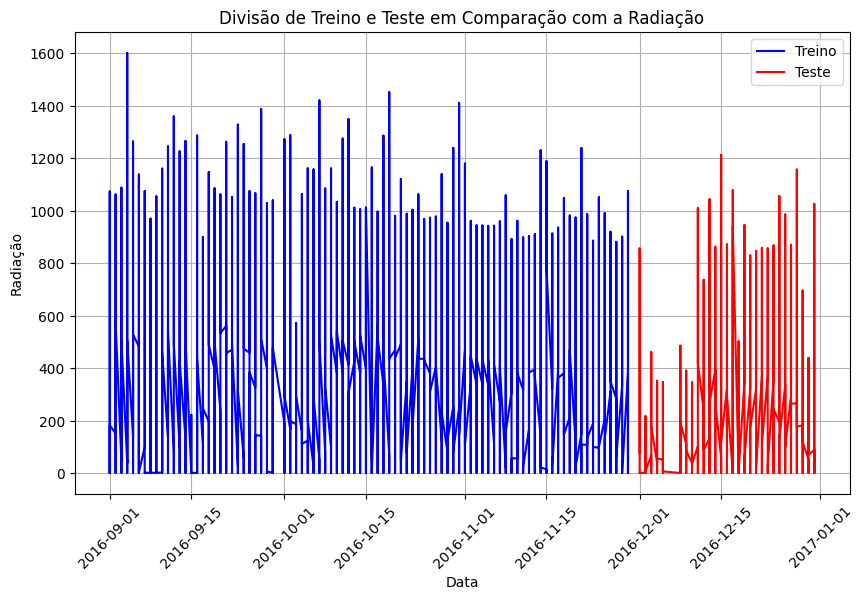

In [67]:
# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(treino['Data'], treino['Radiation'], label='Treino', color='blue')
plt.plot(teste['Data'], teste['Radiation'], label='Teste', color='red')

plt.xlabel('Data')
plt.ylabel('Radiação')
plt.title('Divisão de Treino e Teste em Comparação com a Radiação')
plt.legend()
plt.grid(True)

# Rotacionar as datas no eixo x para facilitar a leitura (opcional)
plt.xticks(rotation=45)

plt.show()

In [88]:
# Dividir as variáveis de treino e teste
X_treino = treino.drop(['Data', 'Radiation', 'Time', 'UNIXTime', 'TimeSunRise', 'TimeSunSet', 'Estação do Ano', 'Ano', 'HoraSunRise'], axis=1)
y_treino = treino['Radiation']

X_teste = teste.drop(['Data', 'Radiation', 'Time', 'UNIXTime', 'TimeSunRise', 'TimeSunSet', 'Estação do Ano', 'Ano', 'HoraSunRise'], axis=1)
y_teste = teste['Radiation']

In [69]:
print(X_treino.shape, y_treino.shape, X_teste.shape, y_teste.shape)

total_linhas = len(treino) + len(teste)
porcentagem_treino = len(treino) / total_linhas * 100
porcentagem_teste = len(teste) / total_linhas * 100

print(f"Porcentagem de dados de treino: {porcentagem_treino:.2f}%")
print(f"Porcentagem de dados de teste: {porcentagem_teste:.2f}%")

(24522, 11) (24522,) (8164, 11) (8164,)
Porcentagem de dados de treino: 75.02%
Porcentagem de dados de teste: 24.98%


In [70]:
# Normalização
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
colunas_treino = X_treino.columns[:5]
colunas_teste = X_teste.columns[:5]

X_treino[colunas_treino] = scaler.fit_transform(X_treino[colunas_treino])
X_teste[colunas_teste] = scaler.transform(X_teste[colunas_teste])

In [85]:
# Treinar o modelo

modelo_xgb = xgb.XGBRegressor(n_estimators = 1000, max_depth=2, learning_rate=0.01)
modelo_xgb.fit(X_treino, y_treino, eval_set = [(X_treino, y_treino), (X_teste, y_teste)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Figure size 1000x600 with 0 Axes>

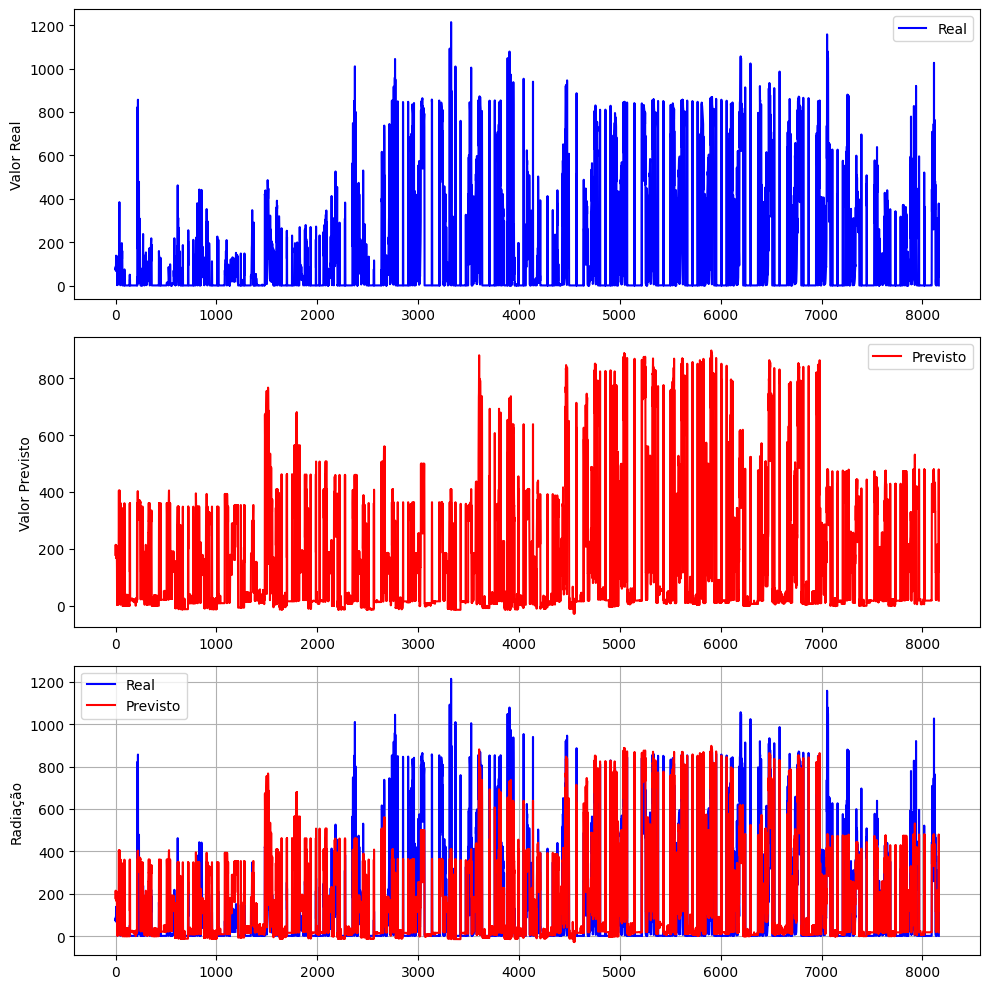

In [86]:
y_pred = modelo_xgb.predict(X_teste)
# Redefinir os índices do DataFrame de teste
teste_redefinido = teste.reset_index(drop=True)

# Plot do gráfico real x predito
plt.figure(figsize=(10, 6))

# Plot dos três gráficos sobrepostos
plt.figure(figsize=(10, 10))

# Plotar o gráfico real no primeiro eixo
ax1 = plt.subplot(3, 1, 1)
ax1.plot(teste_redefinido.index, y_teste, label='Real', color='blue')
ax1.set_ylabel('Valor Real')
ax1.legend()

# Plotar o gráfico previsto no segundo eixo
ax2 = plt.subplot(3, 1, 2)
ax2.plot(teste_redefinido.index, y_pred, label='Previsto', color='red')
ax2.set_ylabel('Valor Previsto')
ax2.legend()

# Plotar o gráfico de resíduos no terceiro eixo
ax3 = plt.subplot(3, 1, 3)
ax3.plot(teste_redefinido.index, y_teste, label='Real', color='blue')
ax3.plot(teste_redefinido.index, y_pred, label='Previsto', color='red')
ax3.set_ylabel('Radiação')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

Importância dos atributos:
1. Temperature: 0.6334949731826782
2. Hora: 0.1808728277683258
3. WindDirection(Degrees): 0.08170025795698166
4. HoraSunSet: 0.025692883878946304
5. Dia: 0.022447282448410988
6. Humidity: 0.02099805697798729
7. Mês: 0.0192182008177042
8. Pressure: 0.01090373657643795
9. Speed: 0.004671838600188494
10. HoraSunRise: 0.0


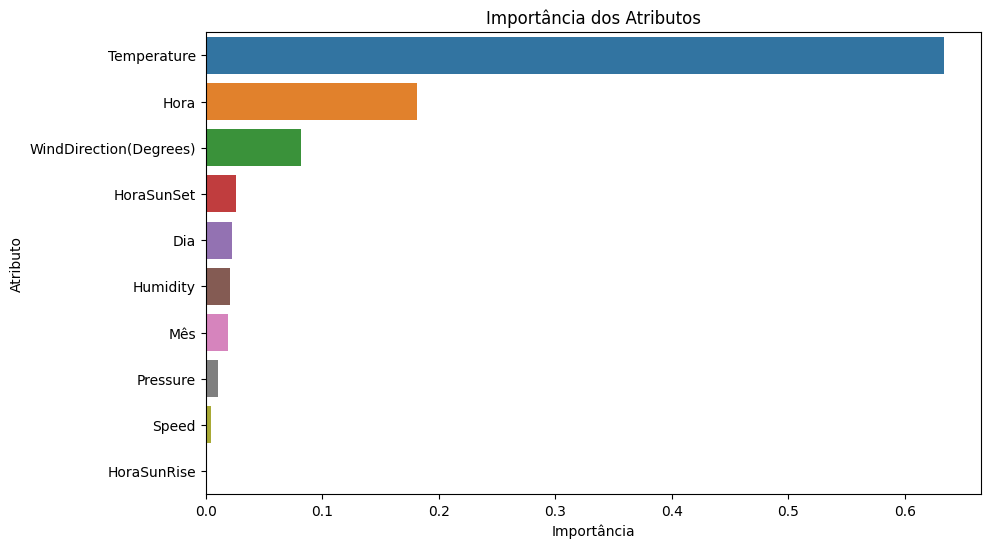

In [87]:
# Plotar a importância dos recursos
importances = modelo_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Exibir a importância de cada atributo
print("Importância dos atributos:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {X_treino.columns[idx]}: {importances[idx]}")

# Plot da importância de cada atributo
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X_treino.columns[indices])
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.title('Importância dos Atributos')
plt.show()


In [ ]:
area_tetuao = 41.9
area_hawaii = 28.3

